In [1]:
%config Completer.use_jedi = False

In [3]:
#importing necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
    import re

    import nltk
    from nltk import word_tokenize
    
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eight\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#fxn for tokenization
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

In [6]:
#fnx for removing stopwords
stop_words = set(stopwords.words("english"))
    
def remove_stopwords(text):
    output= [i for i in text if i not in stop_words]
    return output
    

In [7]:
#fxn for lemmatizing
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [25]:
#making a pipleline for text pre-processing:
def text_preprocessing(column_name):
    
    #converting to a string:
    
    df[column_name] = df[column_name].apply(str)
    
    #Noise removal: removing all full stops and special charechters (expect spaces) from title and text
    
    df[column_name] = df[column_name].str.replace(r'[^a-zA-Z ]+', '', regex = True)
    
    #lowercasing the data:
    
    df[column_name] = df[column_name].astype(str).str.lower()
    
    #tokenizing the data:

    df[column_name]= df[column_name].apply(lambda x: tokenization(x))
    
    df[column_name] = ''.join([word for word in df[column_name]  if len(word) > 4])

    
    #removing stopwords:
    
    df[column_name]= df[column_name].apply(lambda x:remove_stopwords(x))
    
    
    
    #Lemmetizing the data

    df[column_name]=df[column_name].apply(lambda x:lemmatizer(x))
    
    return df

In [26]:
#reading the data
df = pd.read_csv("legal_text_classification.csv")
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [27]:
df['concatenated'] = df['case_title'].map(str) + df['case_text'].map(str)

In [28]:
df = text_preprocessing('concatenated')

In [29]:
df.head()

,case_id,case_outcome,case_title,case_text,concatenated
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,[]
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,[]
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,[]
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,[]
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,[]


In [13]:
#assigning IDs to each type of case type

df['category_id'] = df['case_outcome'].factorize()[0]
category_id_df = df[['case_outcome', 'category_id']].drop_duplicates()


category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'case_outcome']].values)

<AxesSubplot:xlabel='case_outcome'>

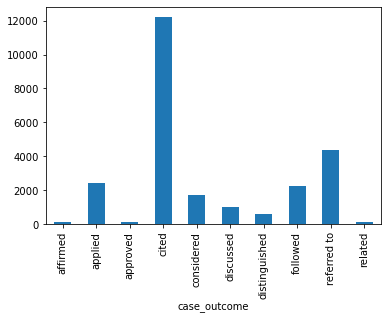

In [13]:
df.groupby('case_outcome')['case_id'].count().plot.bar()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer 

In [15]:
#flattening the list
    
df['concatenated'] = sum(df['concatenated'] , [])

In [16]:
#need help: how to remove smaller words, can tokenize each word and the check its length

df['concatenated'] = [i for i in df['concatenated'] if len(df['concatenated']) > 3]

In [17]:
df['concatenated']

0        alpine hardwood aust pty ltd v hardys pty ltd ...
1        black v lipovac  fca     alr the general princ...
2        colgate palmolive co v cussons pty ltd   fcr o...
3        dais studio pty ltd v bullett creative pty ltd...
4        dr martens australia pty ltd v figgins holding...
                               ...                        
24980    reches pty ltd v tadiran pty ltd   fcr that is...
24981    sir lindsay parkinson amp co ltd v triplan ltd...
24982    spiel v commodity brokers australia pty ltd in...
24983    tullock ltd v walker unreported supreme court ...
24984    yandil holdings pty ltd v insurance co of nort...
Name: concatenated, Length: 24985, dtype: object

In [18]:
#Making the vocabulary list for TF-IDF vectorizer, check frequency staring from 10 and then see repetionin of words, can also check tfidf for vocab

In [19]:
def word_freq(df, case_type, x=50):
    cv = CountVectorizer(encoding = 'utf-8',
                        stop_words = 'english',
                        ngram_range = (1,1), #make same as TF-IDF range
                        analyzer = 'word',
                        max_df = 5000,
                        min_df = 1)
    data = df[df.case_outcome==case_type]
    cv_fit = cv.fit_transform(data['concatenated']).toarray()
    df = pd.DataFrame(data={"Words":cv.get_feature_names(), 'Freq':cv_fit.sum(axis = 0)})
    df = df.sort_values(by = 'Freq', ascending = False)
    df = df.reset_index(drop=True)
    return (df.head(x))

In [57]:
word_freq(df, 'cited', 20)

,Words,Freq
0,act,14135
1,hca,12866
2,clr,12374
3,evidence,11218
4,case,11093
5,fcr,9980
6,tribunal,9883
7,australia,9754
8,applicant,9270
9,mr,8938


In [58]:
cited_vocab = word_freq(df, 'cited', 20).Words[0:20]

In [59]:
word_freq(df, 'referred to', 20)

,Words,Freq
0,court,7805
1,pty,6089
2,fca,4571
3,act,4409
4,hca,4340
5,clr,4164
6,mr,3731
7,case,3676
8,minister,3507
9,fcr,3337


In [60]:
referred_vocab = word_freq(df, 'referred to', 20).Words[0:20]

In [61]:
word_freq(df, 'applied', 20)

,Words,Freq
0,court,6815
1,pty,4412
2,act,4302
3,case,4000
4,clr,3863
5,hca,3671
6,tribunal,3347
7,evidence,3155
8,decision,2959
9,applicant,2691


In [62]:
applied_vocab = word_freq(df, 'applied', 20).Words[0:20]

In [63]:
word_freq(df, 'followed', 20)

,Words,Freq
0,court,5729
1,act,3671
2,pty,3480
3,fca,3087
4,tribunal,3009
5,case,2708
6,decision,2611
7,hca,2581
8,minister,2434
9,clr,2356


In [64]:
followed_vocab = word_freq(df, 'followed', 20).Words[0:20]

In [65]:
word_freq(df, 'considered', 20)

,Words,Freq
0,court,5270
1,legal,3547
2,case,3401
3,privilege,3377
4,act,3035
5,awb,2948
6,evidence,2862
7,advice,2785
8,documents,2696
9,pty,2499


In [66]:
considered_vocab = word_freq(df, 'considered', 20).Words[0:20]

In [67]:
word_freq(df, 'discussed', 20)

,Words,Freq
0,court,3605
1,act,2577
2,case,2134
3,pty,1757
4,clr,1666
5,hca,1628
6,evidence,1624
7,decision,1522
8,said,1519
9,australia,1295


In [68]:
discussed_vocab = word_freq(df, 'discussed', 20).Words[0:20]

In [69]:
word_freq(df, 'distinguished', 20)

,Words,Freq
0,court,1475
1,case,1282
2,act,1003
3,decision,885
4,tribunal,867
5,pty,836
6,application,779
7,applicant,773
8,fca,693
9,mr,684


In [70]:
distinguished_vocab = word_freq(df, 'distinguished', 20).Words[0:20]

In [71]:
word_freq(df, 'related', 20) 

,Words,Freq
0,fca,292
1,court,248
2,pty,219
3,applicant,216
4,respondent,215
5,application,199
6,costs,194
7,decision,188
8,act,186
9,appeal,184


In [72]:
related_vocab = word_freq(df, 'related', 20).Words[0:20]

In [73]:
word_freq(df, 'affirmed', 20) 

,Words,Freq
0,tribunal,479
1,appellant,332
2,decision,318
3,application,274
4,minister,254
5,federal,229
6,court,214
7,fmca,204
8,immigration,203
9,review,187


In [74]:
affirmed_vocab = word_freq(df, 'affirmed', 20).Words[0:20]

In [75]:
word_freq(df, 'approved', 20) 

,Words,Freq
0,privilege,917
1,legal,902
2,awb,848
3,advice,770
4,documents,673
5,evidence,414
6,document,386
7,court,357
8,waiver,341
9,professional,276


In [76]:
approved_vocab = word_freq(df, 'approved', 20).Words[0:20]

In [77]:
total_vocab = approved_vocab.tolist() + affirmed_vocab.tolist() + related_vocab.tolist() + distinguished_vocab.tolist() + discussed_vocab.tolist() + considered_vocab.tolist() + followed_vocab.tolist() + applied_vocab.tolist() + referred_vocab.tolist() + cited_vocab.tolist()

In [ ]:
#can plot word-bag aswell, increase vocab

In [78]:
total_vocab = set(total_vocab)

In [79]:
removal_list = ["court", "fca", "pty", "awb", "mr", "clr", "hca"] #common words, without value for classification

In [80]:
total_vocab = [i for i in total_vocab if i not in(removal_list)]

In [81]:
flatten_preprocessed = df['concatenated']

In [101]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(2, 2), #can try 1-2 aswell
                        stop_words='english',
                       #vocabulary = total_vocab
                       )


features = tfidf.fit_transform(flatten_preprocessed)

labels = df.category_id

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 24985 Text is represented by 169731 features (TF-IDF score of unigrams and bigrams)


In [102]:
N = 3
for Outcome, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Outcome))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> affirmed:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: affairs fmca, citizenship fmca, fmca nan

==> applied:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: mr scotts, mzwxc minister, mzwqh minister

==> approved:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: corporations international, alr agreed, notional entitlement

==> cited:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: honour said, pty atpr, amp citizenship

==> considered:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: mr bryant, pooling proposal, mr hicks

==> discussed:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: davids giudice, rent review, affidavit discovery

==> distinguished:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: northern railway, mayor aldermen, cox lr

==> followed:
  * Most Correlated Unigrams are: 
  * Most Correlated Bigrams are: fca fca, immigration 

In [103]:
X = df['concatenated']
y = df['case_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 0)

In [104]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


C:\Users\eight\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\eight\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [105]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.458235,0.008022
LogisticRegression,0.488133,0.003380
MultinomialNB,0.472243,0.005545
RandomForestClassifier,0.487452,0.002013


In [106]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\eight\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['case_outcome'].unique()))
#look at other metrics aswell

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

        cited       0.53      0.97      0.69      3008
      applied       0.54      0.07      0.12       632
     followed       0.67      0.14      0.23       591
  referred to       0.69      0.31      0.43      1067
      related       1.00      0.03      0.06        33
   considered       0.71      0.05      0.10       463
    discussed       0.89      0.03      0.06       263
distinguished       1.00      0.04      0.07       136
     affirmed       0.75      0.12      0.21        24
     approved       0.00      0.00      0.00        30

     accuracy                           0.55      6247
    macro avg       0.68      0.18      0.20      6247
 weighted avg       0.61      0.55      0.45      6247



C:\Users\eight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eight\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


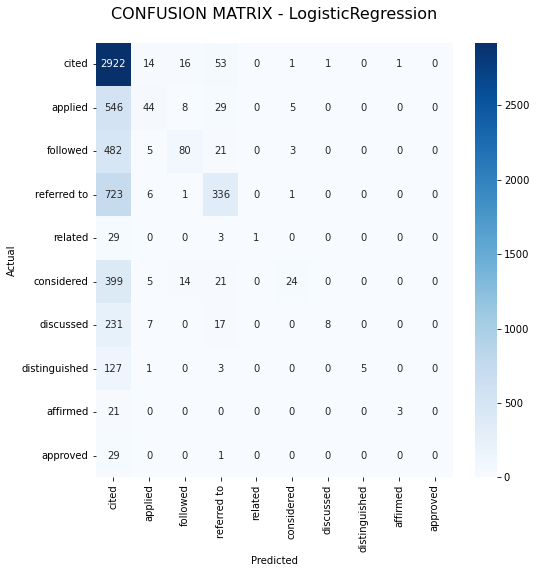

In [108]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.case_outcome.values, 
            yticklabels=category_id_df.case_outcome.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LogisticRegression\n", size=16);